# Which Standard Deviation?

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1d9fe9p/q_when_do_we_use_t_and_when_t1_for_computation_of/).

> When do we use N and when N-1 for computation of sd and cov?
>
> So I was doing a task, where I had a portfolio of shares and I was given their yields. Then I had to calculate [covariance], [standard deviation] etc. But I simply do not know when to use N and when N-1. I only know that it has to do something with degrees of freedom. Can someone explain it to me like to a 10 year old? Thanks!

If you look up the formula for standard deviation, you are likely to find two versions. One has the sample size, `N`, in the denominator; the other has `N-1`. 

Sometimes the explanation of when you should use each of them is not clear. And to make it more confusing, some software packages compute the `N` version by default, and some the `N-1` version.

Let's see if we can straighten it all out.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/XXX.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

In [2]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

## Samples and Populations

Suppose we are given a sequence of numbers and asked to compute the standard deviation.
As an example, we'll use the sequence from 0 to 9.

In [3]:
N = 10
data = np.arange(N)
data

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

The first step is to compute the mean.

In [4]:
m = np.mean(data)
m

4.5

The deviations are the distances of each point from the mean.

In [5]:
deviations = data - m
deviations

array([-4.5, -3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5])

Next we compute the sum of the squared deviations.

In [6]:
ssd = np.sum(deviations **2)
ssd

82.5

Then we compute the variance -- we'll start with the version that has `N` in the denominator.

In [7]:
var = ssd / N

Finally, the standard deviation is the square root of variance.

In [8]:
std = np.sqrt(var)
std

2.8722813232690143

And here's the version with `N-1` in the denominator.

In [9]:
var = ssd / (N-1)
std = np.sqrt(var)
std

3.0276503540974917

With `N=10`, the difference between the version is non-negligible, but this is pretty much the worst case. With larger sample sizes, the difference in smaller -- and with smaller sample sizes, you probably shouldn't compute a standard deviation at all.

By default, NumPy computes the `N` version.

In [10]:
np.std(data)

2.8722813232690143

But with the optional argument `ddof=1`, it computes the `N-1` version.

In [11]:
np.std(data, ddof=1)

3.0276503540974917

By default, Pandas computes the `N-1` version.

In [12]:
pd.Series(data).std()

3.0276503540974917

But with the optional argument `ddof=0`, it computes the `N` version.

In [13]:
pd.Series(data).std(ddof=0)

2.8722813232690143

It is not ideal that the two libraries have different default behavior.
And it might not be obvious why the parameter that controls this behavior is called `ddof`.

The answer is related to OP's question about "degrees of freedom".
To understand that term, suppose I ask you to think of three numbers.
You are free to choose any first number, any second number, and any third number.
In that case, you have three degrees of freedom.

Now suppose I ask you to think of three numbers, but they are required to add up to 10.
You are free to choose the first and second numbers, but then the third number is determined by the requirement. So you have only two degrees of freedom.

If we are given a dataset with `N` elements, we generally assume that it has `N` degrees of freedom unless we are told otherwise.
That's what the `ddof` parameter does.
It stands for "delta degrees of freedom", where "delta" indicates a change or a difference.
In this case, it is the difference between the presumed degrees of freedom, `N`, and the degrees of freedom that should be used for the computation, `N - ddof`.

So, with `ddof=0`, the denominator is `N`. With `ddof=1`, the denominator is `N-1`.

## Which one is right?

So when should you use one or the other? It depends on whether you are describing data or making a statistical inference.

* The `N` version is a descriptive statistic -- it is quantifies the variability of the data.

* The `N-1` version is an estimator -- if `data` is a sample from a population, we can use it to infer the standard deviation of the population.

To be more specific, the `N-1` version is an almost unbiased estimator, which means that it gets the answer almost right, on average, in the long run.
Let's see how that works.

Consider a uniform distribution from 0 to 10.

In [14]:
from scipy.stats import uniform

dist = uniform(0, 10)

Here are the actual mean and standard deviation of this distribution, computed analytically.

In [15]:
dist.mean(), dist.std()

(5.0, 2.8867513459481287)

If we generate a large random sample from this distribution, we expect its standard deviation to be close to 2.9.

In [16]:
sample = dist.rvs(size=10000)
sample.std(ddof=0), sample.std(ddof=1)

(2.8816683774305085, 2.881812471656537)

It is, and with a large sample size, the difference between the `N` version and the `N-1` version is negligible.

But let's see what happens if we generate small samples many times.
First we'll compute the `N` version of the standard deviation for 10001 samples.

In [17]:
standard_deviations_N = [dist.rvs(N).std(ddof=0) for i in range(10001)]

Ideally, the mean of these estimates should be close to the actual mean of the distribution, which is about 2.9.

In [18]:
np.mean(standard_deviations_N)

2.6966272770954323

But it's not -- it is too low on average, which means it is a biased estimator.

Let's see if the `N-1` version is better.

In [19]:
standard_deviations_Nminus1 = [dist.rvs(N).std(ddof=1) for i in range(10001)]

np.mean(standard_deviations_Nminus1)

2.8482429099753923

Yes! The `N-1` version is a much less biased estimator of the standard deviation.

That's why the `N-1` version is called the "sample standard deviation", because it is appropriate when we are using a sample to estimate the standard deviation of a population.

If, instead, we are able to measure an entire population, we can use the `N` version -- which is why it is called the "population standard deviation".

## Should we care?

On one hand, it is impressive that such a simple correction yields a much better estimator. On the other hand, it almost never matters in practice.

* If you have a large sample, the difference between the two versions is negligible.

* If you have a small sample, you can't make a precise estimate of the standard deviation anyway.

To demonstrate the second point, let's look at the distributions of the estimates using the two versions.

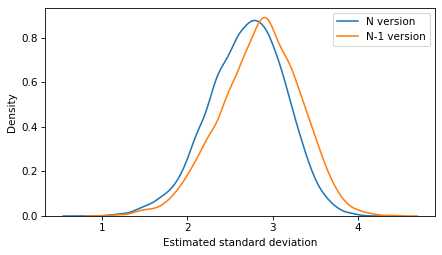

In [20]:
sns.kdeplot(standard_deviations_N, label='N version')
sns.kdeplot(standard_deviations_Nminus1, label='N-1 version')

decorate(xlabel='Estimated standard deviation')

Compared to the variation in the estimates, the difference between the versions is small.

In summary, if your sample size is small and it is really important to avoid underestimating the standard deviation, use the `N-1` correction.
Otherwise it doesn't matter.

In [23]:
data = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
np.std(data)

2.8722813232690143

In [24]:
pd.Series(data).std()

3.0276503540974917

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)